Restoring offline with a salt flux - after Dougie's fixed the bug.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
import xarray as xr
import cmocean.cm as cmocean
import glob
import shutil as shutil

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

In [2]:
from os import environ
environ["PYTHONWARNINGS"] = "ignore"

from dask.distributed import Client
client = Client(threads_per_worker=1)
client

<Client: 'tcp://127.0.0.1:38893' processes=28 threads=28, memory=125.19 GiB>

# Monthly restoring

In [38]:
path_rest_on = np.sort(glob.glob('/g/data/ol01/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/output*/*ocean_month.nc'))[24:30]
path_rest_pc_mon = np.sort(glob.glob('/scratch/x77/jn8053/mom6/archive/panant-01-zstar-prsc-rest-TESTS/test_monthly_salt_fluxes/output*/*ocean_month.nc'))

In [5]:
def preprocess(ds):
    ds = ds['salt_flux_added']
    return ds

In [7]:
sfa_rest_on = xr.open_mfdataset(path_rest_on, preprocess=preprocess, parallel=True, chunks='auto')['salt_flux_added']
sfa_rest_pc_mon = xr.open_mfdataset(path_rest_pc_mon, preprocess=preprocess, parallel=True, chunks='auto')['salt_flux_added']

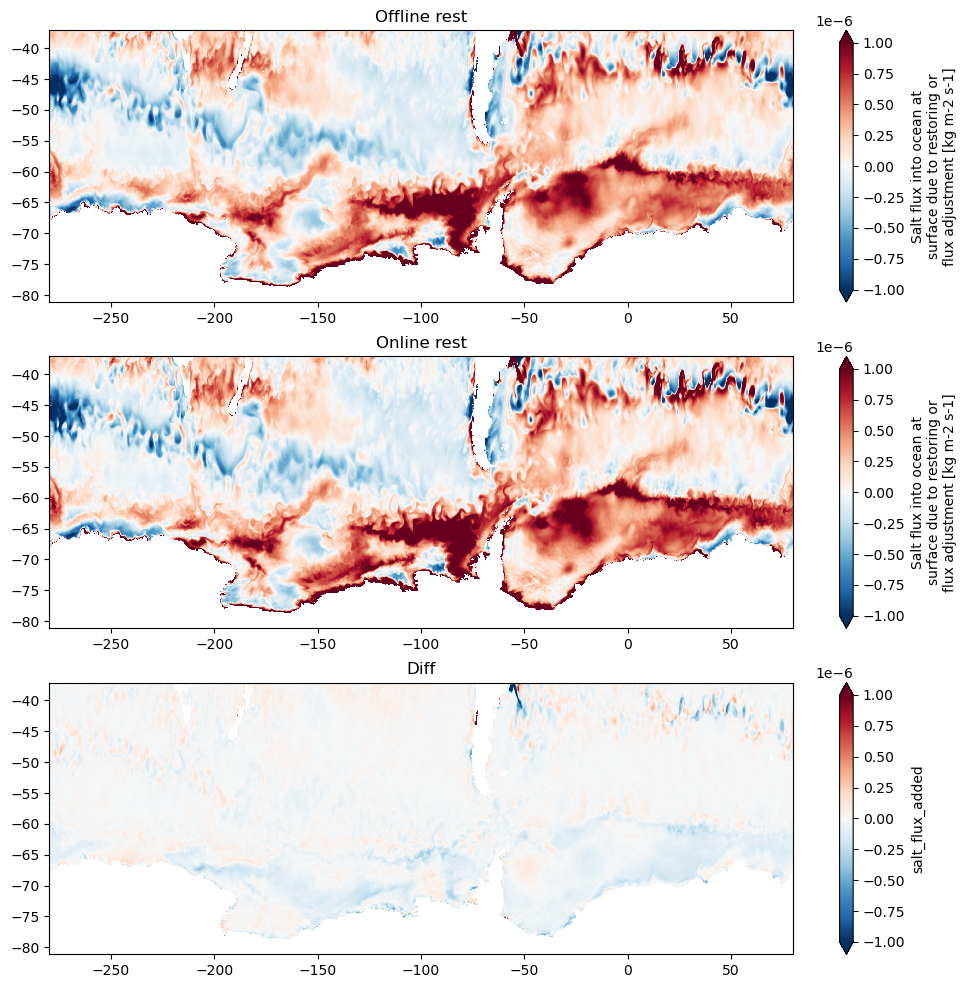

In [46]:
fig, axs = plt.subplots(3, 1, figsize=(12, 12))
vmin=-1e-6; vmax=1e-6;

(sfa_rest_pc_mon.isel(time=0)).plot(ax=axs[0], vmin=vmin, vmax=vmax, cmap='RdBu_r'); axs[0].set_title('Offline rest')
(sfa_rest_on.isel(time=0)).plot(ax=axs[1], vmin=vmin, vmax=vmax, cmap='RdBu_r'); axs[1].set_title('Online rest')
(sfa_rest_pc_mon.isel(time=0)-sfa_rest_on.isel(time=0)).plot(ax=axs[2], vmin=vmin, vmax=vmax, cmap='RdBu_r'); axs[2].set_title('Diff');
for ax in axs:
    ax.set_xlabel(''); ax.set_ylabel('');

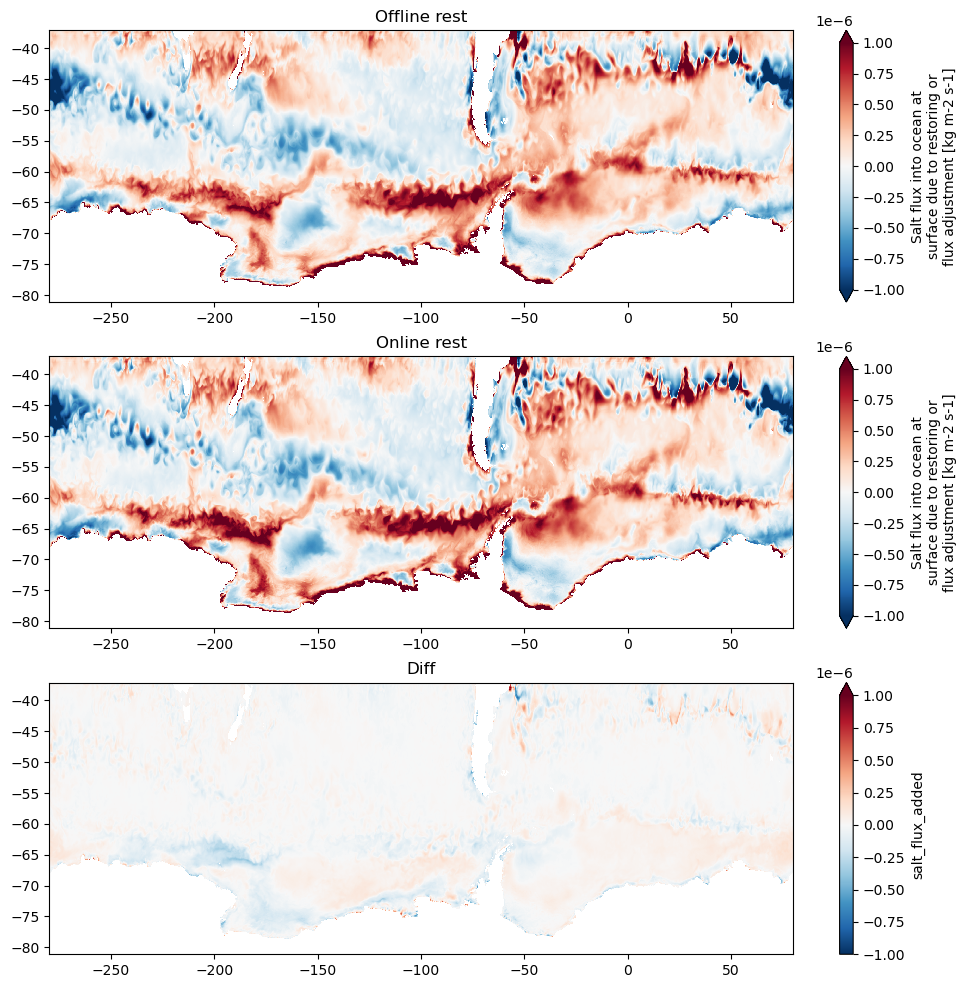

In [45]:
fig, axs = plt.subplots(3, 1, figsize=(12, 12))
vmin=-1e-6; vmax=1e-6;

(sfa_rest_pc_mon.isel(time=-1)).plot(ax=axs[0], vmin=vmin, vmax=vmax, cmap='RdBu_r'); axs[0].set_title('Offline rest')
(sfa_rest_on.isel(time=-1)).plot(ax=axs[1], vmin=vmin, vmax=vmax, cmap='RdBu_r'); axs[1].set_title('Online rest')
(sfa_rest_pc_mon.isel(time=-1)-sfa_rest_on.isel(time=-1)).plot(ax=axs[2], vmin=vmin, vmax=vmax, cmap='RdBu_r'); axs[2].set_title('Diff');
for ax in axs:
    ax.set_xlabel(''); ax.set_ylabel('');

Check salt

In [40]:
path_rest_on = np.sort(glob.glob('/g/data/ol01/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/output*/*ocean_month_z.nc'))[24:30]
path_rest_pc_mon = np.sort(glob.glob('/scratch/x77/jn8053/mom6/archive/panant-01-zstar-prsc-rest-TESTS/test_monthly_salt_fluxes/output*/*ocean_month_z.nc'))

In [41]:
def preprocess(ds):
    ds = ds['so'].isel(z_l=0)
    return ds

In [42]:
so_rest_on = xr.open_mfdataset(path_rest_on, preprocess=preprocess, parallel=True, chunks='auto')['so']
so_rest_pc_mon = xr.open_mfdataset(path_rest_pc_mon, preprocess=preprocess, parallel=True, chunks='auto')['so']

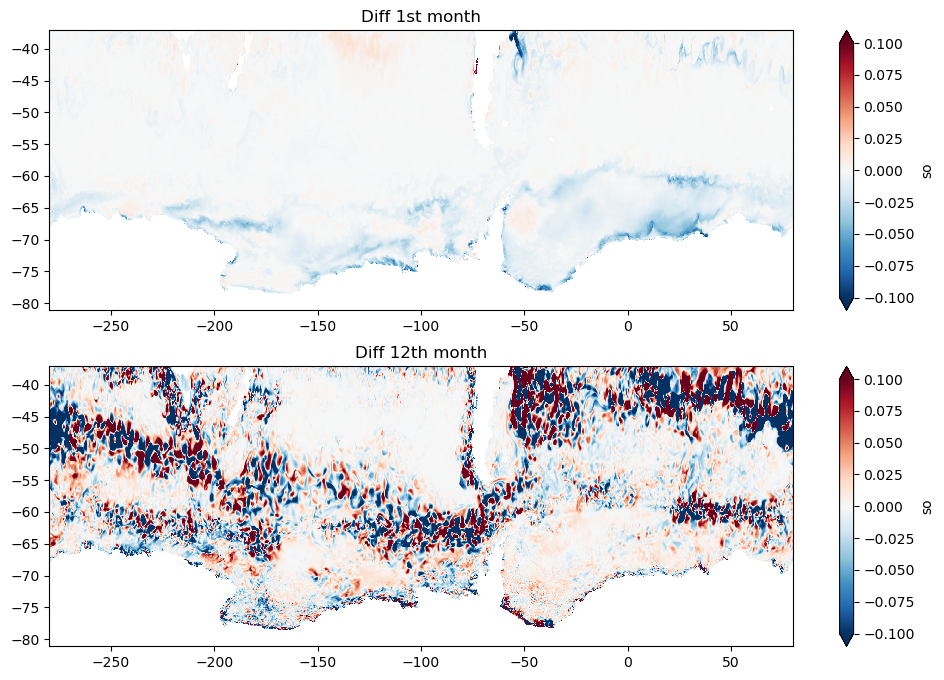

In [44]:
fig, axs = plt.subplots(2, 1, figsize=(12, 8))
vmin=-.1; vmax=.1;

(so_rest_pc_mon.isel(time=0)-so_rest_on.isel(time=0)).plot(ax=axs[0], vmin=vmin, vmax=vmax, cmap='RdBu_r'); axs[0].set_title('Diff 1st month');
(so_rest_pc_mon.isel(time=-1)-so_rest_on.isel(time=-1)).plot(ax=axs[1], vmin=vmin, vmax=vmax, cmap='RdBu_r'); axs[1].set_title('Diff 12th month');
for ax in axs:
    ax.set_xlabel(''); ax.set_ylabel('');

Quick average over the shelf

In [11]:
area = xr.open_dataset('/scratch/x77/jn8053/mom6/archive/panant-01-zstar-prsc-rest-TESTS/output020/20010101.ocean_static.nc')['areacello']
shelf_mask = xr.open_dataset('/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_01deg.nc')['contour_masked_above']
shelf_mask = xr.where(shelf_mask!=-1000,1,np.nan)

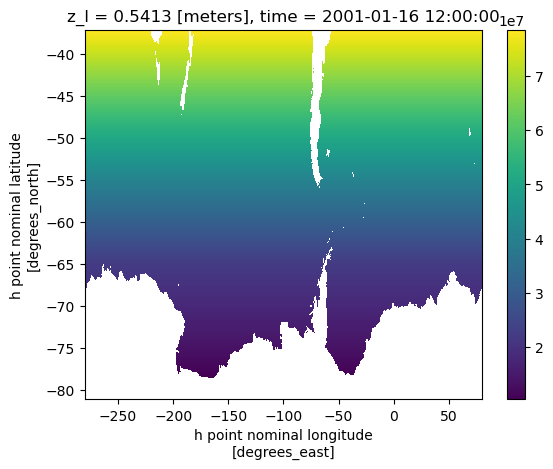

In [26]:
area = area*(so_rest_pc.isel(time=0)*0+1)
area.plot()

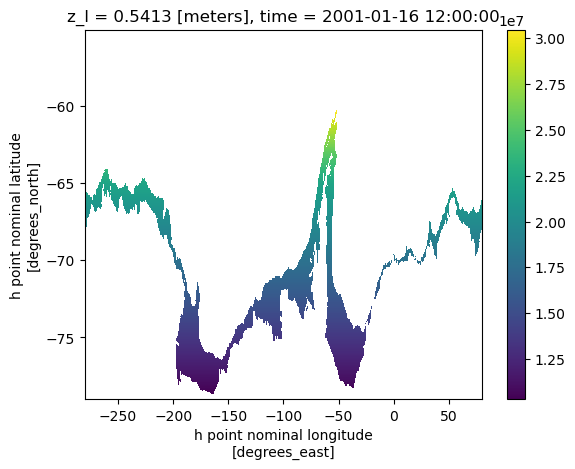

In [27]:
(area*shelf_mask).plot()

In [48]:
area_shelf = (area*shelf_mask).sum(['xh', 'yh'])
sfa_rest_on_int = (sfa_rest_on*area*shelf_mask).sum(['xh', 'yh'])/area_shelf
sfa_rest_pc_int_mon = (sfa_rest_pc_mon*area*shelf_mask).sum(['xh', 'yh'])/area_shelf
so_rest_on_int = (so_rest_on*area*shelf_mask).sum(['xh', 'yh'])/area_shelf
so_rest_pc_int_mon = (so_rest_pc_mon*area*shelf_mask).sum(['xh', 'yh'])/area_shelf

Text(0.5, 1.0, 'salt_flux_added, Ant. shelf')

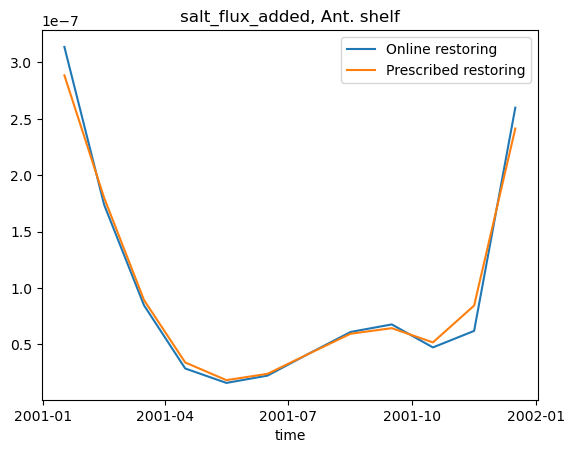

In [49]:
sfa_rest_on_int.plot(label='Online restoring')
sfa_rest_pc_int_mon.plot(label='Prescribed restoring')
plt.legend(); plt.title('salt_flux_added, Ant. shelf')

Text(0.5, 1.0, 'surface_salt, Ant. shelf')

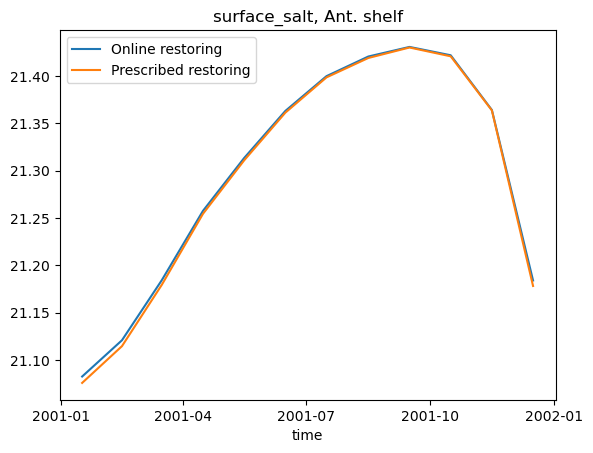

In [50]:
so_rest_on_int.plot(label='Online restoring')
so_rest_pc_int_mon.plot(label='Prescribed restoring')
plt.legend(); plt.title('surface_salt, Ant. shelf')

In [56]:
area_shelf = (area*shelf_mask).sel(xh=slice(-70, -38),yh=slice(None, -73)).sum(['xh', 'yh'])
sfa_rest_on_int_w = (sfa_rest_on*area*shelf_mask).sel(xh=slice(-70, -38),yh=slice(None, -73)).sum(['xh', 'yh'])/area_shelf
sfa_rest_pc_int_w = (sfa_rest_pc*area*shelf_mask).sel(xh=slice(-70, -38),yh=slice(None, -73)).sum(['xh', 'yh'])/area_shelf
so_rest_on_int_w = (so_rest_on*area*shelf_mask).sel(xh=slice(-70, -38),yh=slice(None, -73)).sum(['xh', 'yh'])/area_shelf
so_rest_pc_int_w = (so_rest_pc*area*shelf_mask).sel(xh=slice(-70, -38),yh=slice(None, -73)).sum(['xh', 'yh'])/area_shelf

In [57]:
area_shelf = (area*shelf_mask).sel(xh=slice(-200, -170),yh=slice(None, -73)).sum(['xh', 'yh'])
sfa_rest_on_int_r = (sfa_rest_on*area*shelf_mask).sel(xh=slice(-200, -170),yh=slice(None, -73)).sum(['xh', 'yh'])/area_shelf
sfa_rest_pc_int_r = (sfa_rest_pc*area*shelf_mask).sel(xh=slice(-200, -170),yh=slice(None, -73)).sum(['xh', 'yh'])/area_shelf
so_rest_on_int_r = (so_rest_on*area*shelf_mask).sel(xh=slice(-200, -170),yh=slice(None, -73)).sum(['xh', 'yh'])/area_shelf
so_rest_pc_int_r = (so_rest_pc*area*shelf_mask).sel(xh=slice(-200, -170),yh=slice(None, -73)).sum(['xh', 'yh'])/area_shelf

In [58]:
area_shelf = (area*shelf_mask).sel(xh=slice(50,70)).sum(['xh', 'yh'])
sfa_rest_on_int_p = (sfa_rest_on*area*shelf_mask).sel(xh=slice(50,70)).sum(['xh', 'yh'])/area_shelf
sfa_rest_pc_int_p = (sfa_rest_pc*area*shelf_mask).sel(xh=slice(50,70)).sum(['xh', 'yh'])/area_shelf
so_rest_on_int_p = (so_rest_on*area*shelf_mask).sel(xh=slice(50,70)).sum(['xh', 'yh'])/area_shelf
so_rest_pc_int_p = (so_rest_pc*area*shelf_mask).sel(xh=slice(50,70)).sum(['xh', 'yh'])/area_shelf

In [60]:
area_shelf = (area*shelf_mask).sel(xh=slice(-230,-200)).sum(['xh', 'yh'])
sfa_rest_on_int_a = (sfa_rest_on*area*shelf_mask).sel(xh=slice(-230,-200)).sum(['xh', 'yh'])/area_shelf
sfa_rest_pc_int_a = (sfa_rest_pc*area*shelf_mask).sel(xh=slice(-230,-200)).sum(['xh', 'yh'])/area_shelf
so_rest_on_int_a = (so_rest_on*area*shelf_mask).sel(xh=slice(-230,-200)).sum(['xh', 'yh'])/area_shelf
so_rest_pc_int_a = (so_rest_pc*area*shelf_mask).sel(xh=slice(-230,-200)).sum(['xh', 'yh'])/area_shelf

Text(0.5, 1.0, 'surface_salt, Adelie shelf')

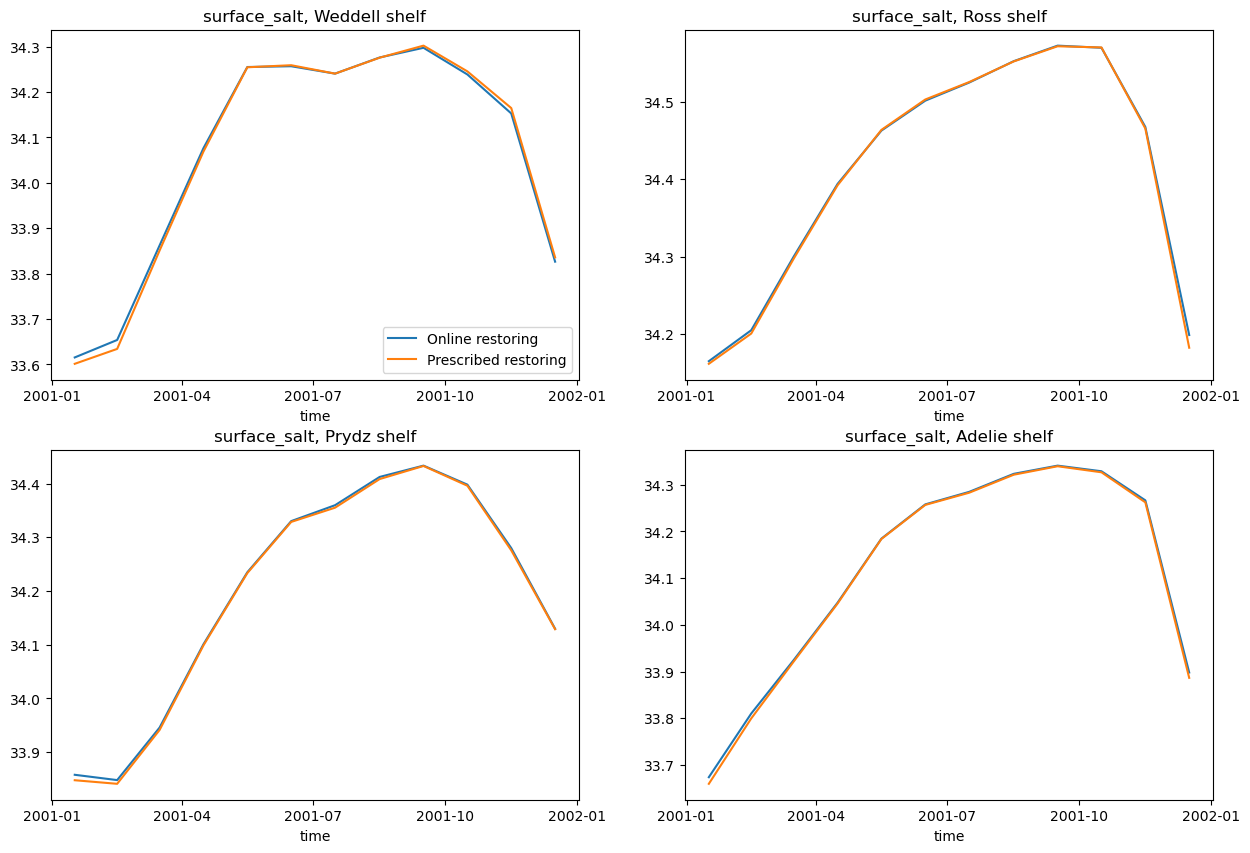

In [65]:
fig, axs = plt.subplots(2,2, figsize=(15,10))
so_rest_on_int_w.plot(ax=axs[0,0], label='Online restoring')
so_rest_pc_int_w.plot(ax=axs[0,0], label='Prescribed restoring')
axs[0,0].legend(); axs[0,0].set_title('surface_salt, Weddell shelf')

so_rest_on_int_r.plot(ax=axs[0,1], label='Online restoring')
so_rest_pc_int_r.plot(ax=axs[0,1], label='Prescribed restoring')
axs[0,1].set_title('surface_salt, Ross shelf')

so_rest_on_int_p.plot(ax=axs[1,0], label='Online restoring')
so_rest_pc_int_p.plot(ax=axs[1,0], label='Prescribed restoring')
axs[1,0].set_title('surface_salt, Prydz shelf')

so_rest_on_int_a.plot(ax=axs[1,1], label='Online restoring')
so_rest_pc_int_a.plot(ax=axs[1,1], label='Prescribed restoring')
axs[1,1].set_title('surface_salt, Adelie shelf')

# Daily restoring

In [15]:
path_rest_on = np.sort(glob.glob('/g/data/ol01/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/output*/*ocean_month.nc'))[24:30]
path_rest_pc_day = np.sort(glob.glob('/scratch/x77/jn8053/mom6/archive/panant-01-zstar-prsc-rest-TESTS/output*/*ocean_month.nc'))

In [16]:
def preprocess(ds):
    ds = ds['salt_flux_added']
    return ds

In [18]:
sfa_rest_on = xr.open_mfdataset(path_rest_on, preprocess=preprocess, parallel=True, chunks='auto')['salt_flux_added']
sfa_rest_pc_day = xr.open_mfdataset(path_rest_pc_day, preprocess=preprocess, parallel=True, chunks='auto')['salt_flux_added']

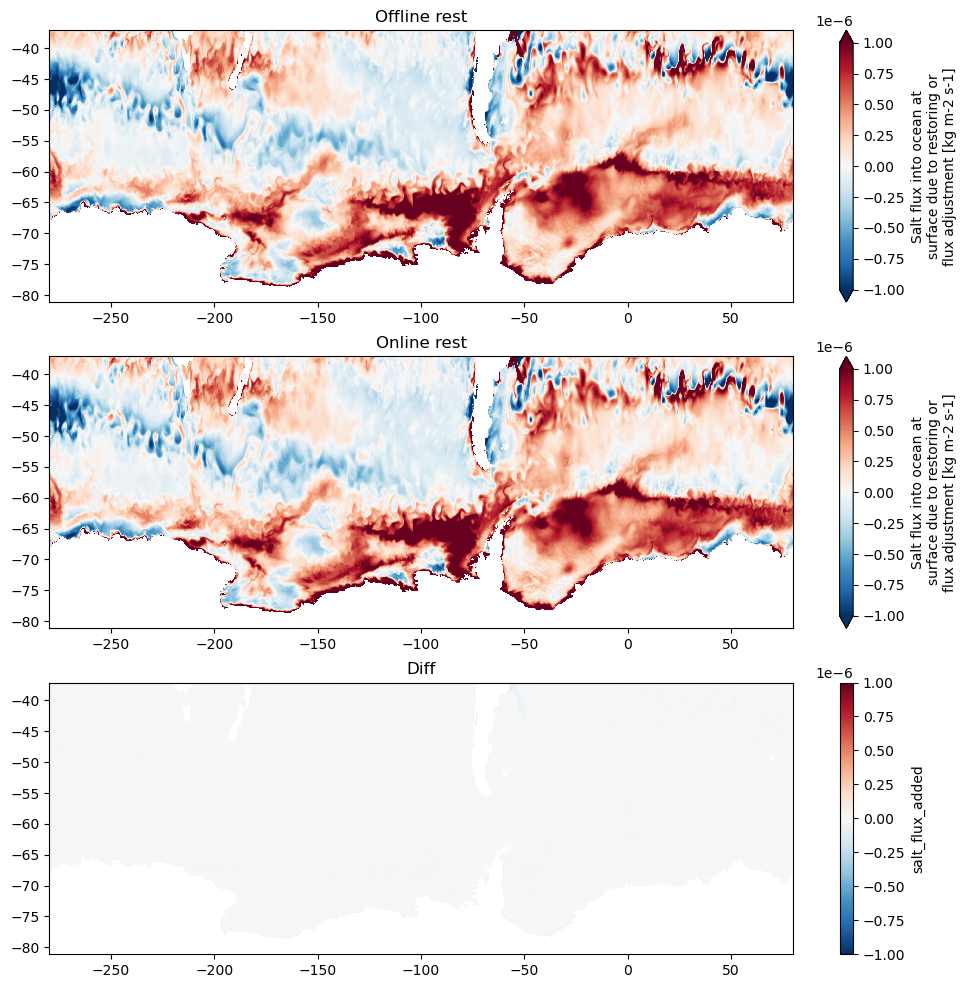

In [19]:
fig, axs = plt.subplots(3, 1, figsize=(12, 12))
vmin=-1e-6; vmax=1e-6;

(sfa_rest_pc_day.isel(time=0)).plot(ax=axs[0], vmin=vmin, vmax=vmax, cmap='RdBu_r'); axs[0].set_title('Offline rest')
(sfa_rest_on.isel(time=0)).plot(ax=axs[1], vmin=vmin, vmax=vmax, cmap='RdBu_r'); axs[1].set_title('Online rest')
(sfa_rest_pc_day.isel(time=0)-sfa_rest_on.isel(time=0)).plot(ax=axs[2], vmin=vmin, vmax=vmax, cmap='RdBu_r'); axs[2].set_title('Diff');
for ax in axs:
    ax.set_xlabel(''); ax.set_ylabel('');

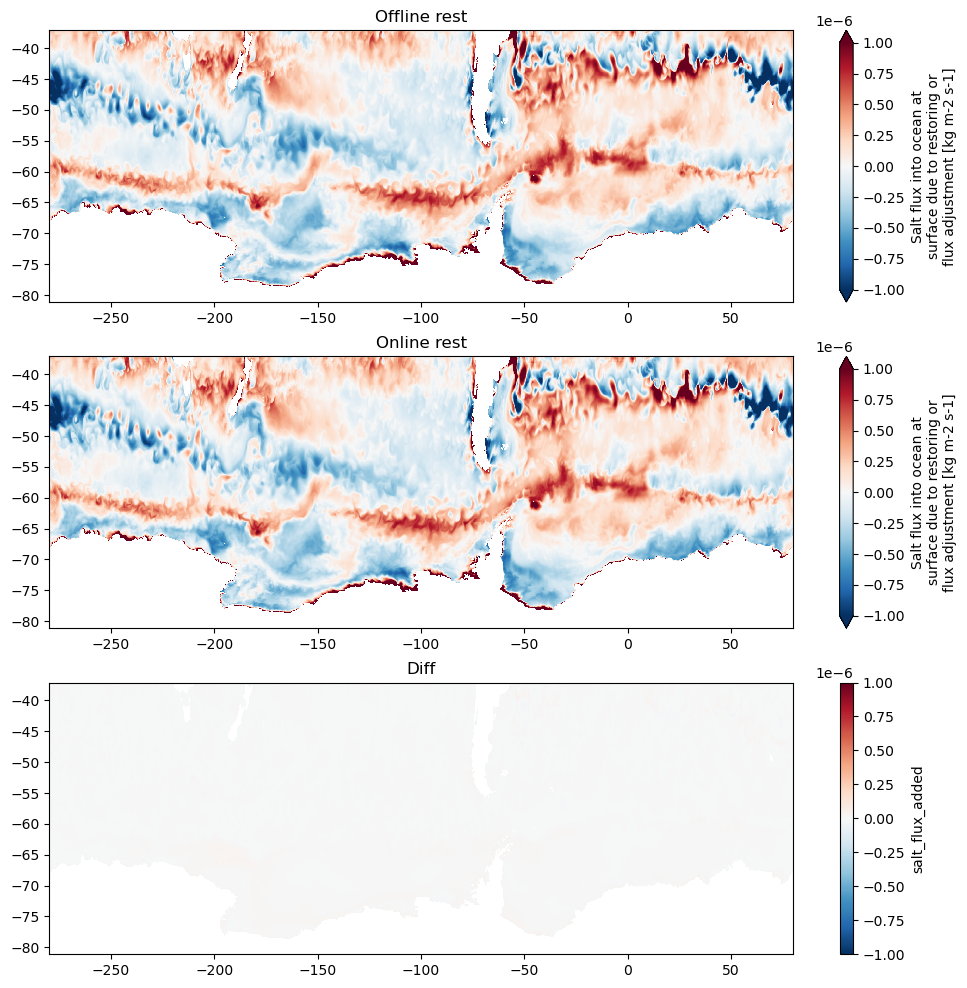

In [20]:
fig, axs = plt.subplots(3, 1, figsize=(12, 12))
vmin=-1e-6; vmax=1e-6;

(sfa_rest_pc_day.isel(time=-1)).plot(ax=axs[0], vmin=vmin, vmax=vmax, cmap='RdBu_r'); axs[0].set_title('Offline rest')
(sfa_rest_on.isel(time=-2)).plot(ax=axs[1], vmin=vmin, vmax=vmax, cmap='RdBu_r'); axs[1].set_title('Online rest')
(sfa_rest_pc_day.isel(time=-1)-sfa_rest_on.isel(time=-2)).plot(ax=axs[2], vmin=vmin, vmax=vmax, cmap='RdBu_r'); axs[2].set_title('Diff');
for ax in axs:
    ax.set_xlabel(''); ax.set_ylabel('');

Check salt

In [21]:
path_rest_on = np.sort(glob.glob('/g/data/ol01/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/output*/*ocean_month_z.nc'))[24:30]
path_rest_pc_day = np.sort(glob.glob('/scratch/x77/jn8053/mom6/archive/panant-01-zstar-prsc-rest-TESTS/output*/*ocean_month_z.nc'))

In [22]:
def preprocess(ds):
    ds = ds['so'].isel(z_l=0)
    return ds

In [23]:
so_rest_on = xr.open_mfdataset(path_rest_on, preprocess=preprocess, parallel=True, chunks='auto')['so']
so_rest_pc_day = xr.open_mfdataset(path_rest_pc_day, preprocess=preprocess, parallel=True, chunks='auto')['so']

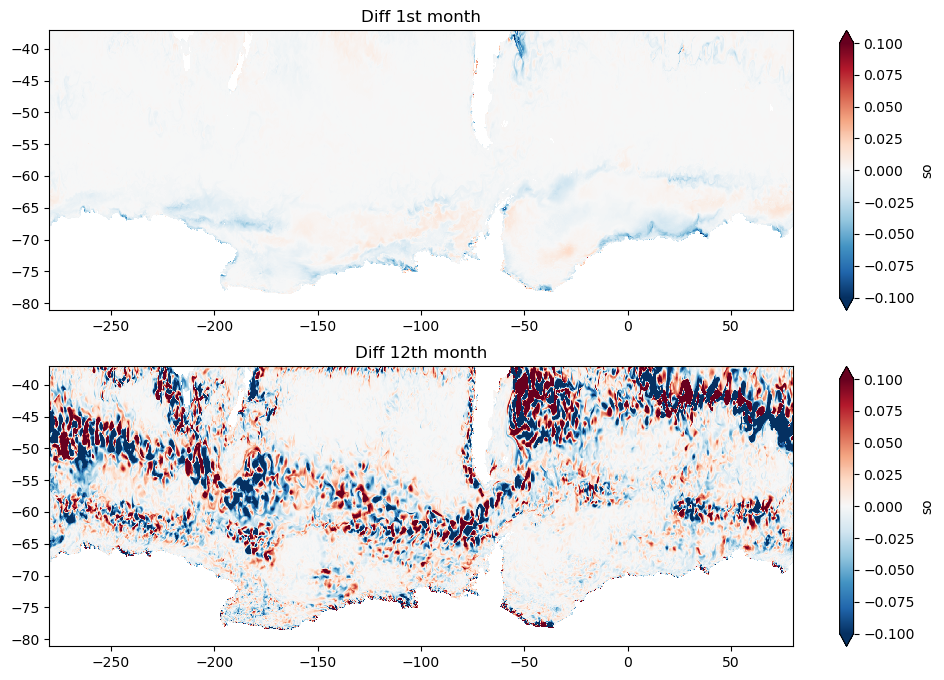

In [25]:
fig, axs = plt.subplots(2, 1, figsize=(12, 8))
vmin=-.1; vmax=.1;

(so_rest_pc_day.isel(time=0)-so_rest_on.isel(time=0)).plot(ax=axs[0], vmin=vmin, vmax=vmax, cmap='RdBu_r'); axs[0].set_title('Diff 1st month');
(so_rest_pc_day.isel(time=-1)-so_rest_on.isel(time=-2)).plot(ax=axs[1], vmin=vmin, vmax=vmax, cmap='RdBu_r'); axs[1].set_title('Diff 12th month');
for ax in axs:
    ax.set_xlabel(''); ax.set_ylabel('');

In [26]:
area_shelf = (area*shelf_mask).sum(['xh', 'yh'])
sfa_rest_on_int = (sfa_rest_on*area*shelf_mask).sum(['xh', 'yh'])/area_shelf
sfa_rest_pc_int_day = (sfa_rest_pc_day*area*shelf_mask).sum(['xh', 'yh'])/area_shelf
so_rest_on_int = (so_rest_on*area*shelf_mask).sum(['xh', 'yh'])/area_shelf
so_rest_pc_int_day = (so_rest_pc_day*area*shelf_mask).sum(['xh', 'yh'])/area_shelf

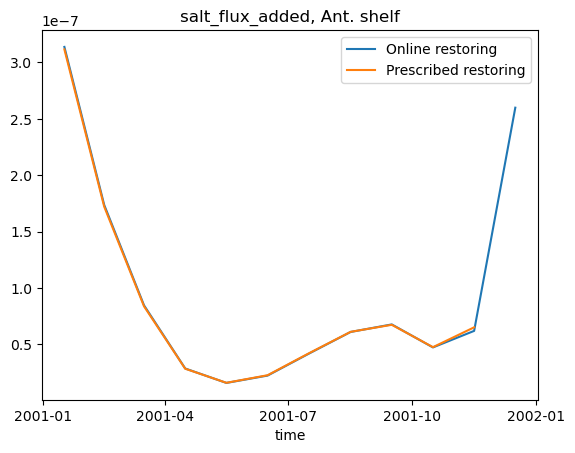

In [28]:
sfa_rest_on_int.plot(label='Online restoring')
sfa_rest_pc_int_day.plot(label='Prescribed restoring')
plt.legend(); plt.title('salt_flux_added, Ant. shelf');

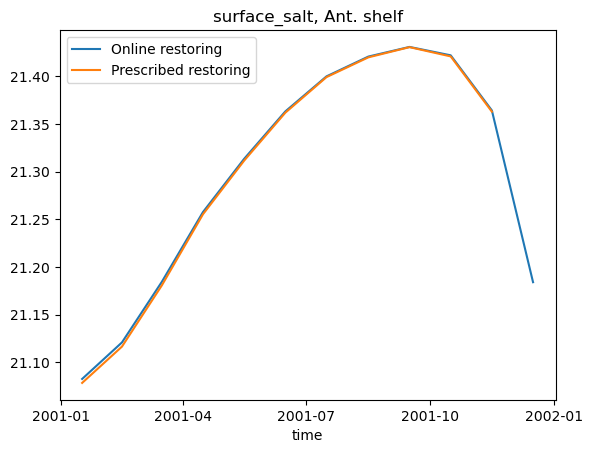

In [29]:
so_rest_on_int.plot(label='Online restoring')
so_rest_pc_int_day.plot(label='Prescribed restoring')
plt.legend(); plt.title('surface_salt, Ant. shelf');

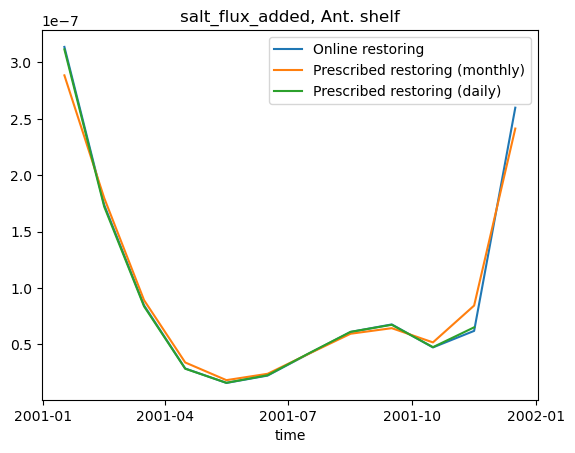

In [51]:
sfa_rest_on_int.plot(label='Online restoring')
sfa_rest_pc_int_mon.plot(label='Prescribed restoring (monthly)')
sfa_rest_pc_int_day.plot(label='Prescribed restoring (daily)')
plt.legend(); plt.title('salt_flux_added, Ant. shelf');

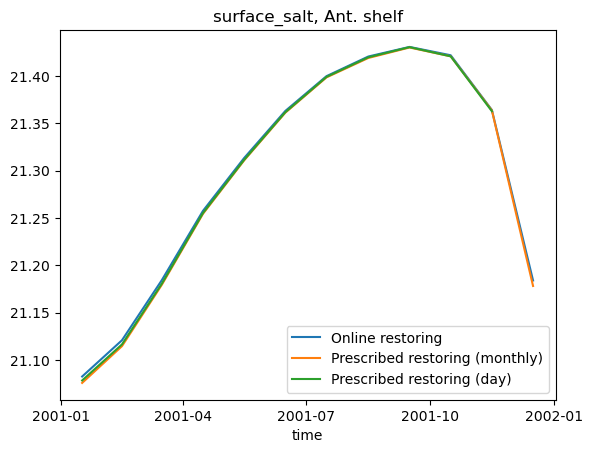

In [52]:
so_rest_on_int.plot(label='Online restoring')
so_rest_pc_int_mon.plot(label='Prescribed restoring (monthly)')
so_rest_pc_int_day.plot(label='Prescribed restoring (day)')
plt.legend(); plt.title('surface_salt, Ant. shelf');

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(12, 8))
vmin=-.1; vmax=.1;

(so_rest_pc_mon.isel(time=-2)-so_rest_on.isel(time=-2)).plot(ax=axs[0], vmin=vmin, vmax=vmax, cmap='RdBu_r'); axs[0].set_title('Diff with monthly');
(so_rest_pc_day.isel(time=-1)-so_rest_on.isel(time=-2)).plot(ax=axs[1], vmin=vmin, vmax=vmax, cmap='RdBu_r'); axs[1].set_title('Diff with daily');
for ax in axs:
    ax.set_xlabel(''); ax.set_ylabel('');